This notebook checks the consistency of batoid and ts_wep.

I take a set of zernikes and create a corresponding perturbed batoid/wfsim simulator. I then simulate a pair of donuts and use ts_wep to estimate the zernikes. I also extract the OPD from batoid. I compare these three sets of zernikes (input, batoid opd, ts_wep estimate) while scaling up/down the amplitude of the zernikes.

There is some discussion at the bottom.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lsst.ts.wep.WfEstimator import WfEstimator
from lsst.ts.wep.Utility import DefocalType, getConfigDir

import batoid
import wfsim
import galsim

/astro/store/epyc/projects/lsst_comm/lsstinstall/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting up the simulations and plotting.

In [2]:
band = "r"

# load the fiducial telescope
telescope = batoid.Optic.fromYaml(f"LSST_{band}.yaml")

# create the wfsim simulator
bandpass = galsim.Bandpass(f"LSST_{band}.dat", wave_type="nm")
observation = {
        'zenith': 30 * galsim.degrees,
        'raw_seeing': 0.7 * galsim.arcsec,  # zenith 500nm seeing
        'wavelength': bandpass.effective_wavelength,
        'exptime': 15.0,  # seconds
        'temperature': 293.,  # Kelvin
        'pressure': 69.,  #kPa
        'H2O_pressure': 1.0  #kPa
    }
atm_kwargs = {
    'screen_size': 819.2,
    'screen_scale': 0.1,
    'nproc': 6  # create screens in parallel using this many CPUs
} 
simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    telescope,
    bandpass,
    name="R00_SW0",
    rng=np.random.default_rng(0),
)

In [3]:
detectorLocations = {
    # bottom left
    "R00": (-0.02075, -0.02075),
    "R00_SW0": (-0.02075, -0.02075),
    "R00_SW1": (-0.02075, -0.02075),
    # top left
    "R40": (-0.02075, +0.02075),
    "R40_SW0": (-0.02075, +0.02075),
    "R40_SW1": (-0.02075, +0.02075),
    # bottom right
    "R04": (+0.02075, -0.02075),
    "R04_SW0": (+0.02075, -0.02075),
    "R04_SW1": (+0.02075, -0.02075),
    # top right
    "R44": (+0.02075, +0.02075),
    "R44_SW0": (+0.02075, +0.02075),
    "R44_SW1": (+0.02075, +0.02075),
}

In [4]:
def plot(stampExtra, stampIntra, zkEst, opd, zk):
    fig, axes = plt.subplot_mosaic(
        """
        ab
        cc
        """,
        figsize=(4, 4),
        dpi=150,
    )

    axes["a"].imshow(stampIntra, origin="lower")
    axes["a"].set(title="Intra", xticks=[], yticks=[])

    axes["b"].imshow(stampExtra, origin="lower")
    axes["b"].set(title="Extra", xticks=[], yticks=[])

    zk_grid = np.arange(4, 23)
    axes["c"].plot(zk_grid, zk, ls="--", c="k", label="input")
    axes["c"].plot(zk_grid, opd, ls="--", c="C1", label="batoid OPD")
    axes["c"].plot(zk_grid, zkEst, label="ts_wep")
    axes["c"].legend(fontsize=8)
    axes["c"].set(xticks=np.arange(4, 23, 2), xlabel="Noll index", ylabel="$\mu m$")
    
    plt.show()

def check_consistency(zk, thx1, thy1, thx2, thy2, seed = 0):
    
    rng = np.random.default_rng(seed)
    
    # determine the chip
    if thx1 > 0:
        if thy1 > 0:
            chip = "R44"
        else:
            chip = "R04"
    else:
        if thy1 > 0:
            chip = "R40"
        else:
            chip = "R00"
    
    # create the perturbed telescope
    R_outer = telescope.pupilSize / 2
    R_inner = R_outer * telescope.pupilObscuration
    phase = batoid.Zernike(
        np.pad(zk, pad_width=(4,0), mode='constant') * 1e-6,
        R_outer=R_outer,
        R_inner=R_inner,
    )
    perturbed = batoid.CompoundOptic(
            (
                batoid.optic.OPDScreen(
                    batoid.Plane(),
                    phase,
                    name="PhaseScreen",
                    obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                    coordSys=telescope.stopSurface.coordSys
                ),
                *telescope.items,
            ),
            name="PerturbedLSST",
            backDist=telescope.backDist,
            pupilSize=telescope.pupilSize,
            inMedium=telescope.inMedium,
            stopSurface=telescope.stopSurface,
            sphereRadius=telescope.sphereRadius,
            pupilObscuration=telescope.pupilObscuration
    )
    
    # set some star settings
    T = 7_000 # K
    nphotons = 1_000_000
    
    # simulate the extrafocal image
    simulator.set_name(f"{chip}_SW0")
    simulator.telescope = perturbed.withGloballyShiftedOptic(
        "Detector", [0, 0, +0.0015]
    )
    simulator.add_star(thx1, thy1, wfsim.BBSED(T), nphotons, rng)

    # cut out the extrafocal stamp
    simulator._construct_wcs()
    x, y = np.array(simulator.wcs.radecToxy(thx1, thy1, galsim.radians))
    x = int(x - simulator.image.xmin)
    y = int(y - simulator.image.ymin)
    stampExtra = simulator.image.array[y-80:y+80, x-80:x+80]
    
    # simulate the intrafocal image
    simulator.set_name(f"{chip}_SW1")
    simulator.telescope = perturbed.withGloballyShiftedOptic(
        "Detector", [0, 0, -0.0015]
    )
    simulator.add_star(thx2, thy2, wfsim.BBSED(T), nphotons, rng)

    # cut out the intrafocal stamp
    simulator._construct_wcs()
    x, y = np.array(simulator.wcs.radecToxy(thx2, thy2, galsim.radians))
    x = int(x - simulator.image.xmin)
    y = int(y - simulator.image.ymin)
    stampIntra = simulator.image.array[y-80:y+80, x-80:x+80]
    
    # setup WfEstimator
    wfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
    wfEst.config(sizeInPix=160, units="um", algo="exp", debugLevel=1)
    wfEst.setImg(
        np.rad2deg([thx1, thy1]),
        DefocalType.Extra,
        image=stampExtra.copy(),
    )
    wfEst.setImg(
        np.rad2deg([thx2, thy2]),
        DefocalType.Intra,
        image=stampIntra.copy(),
    )
    
    # estimate the wavefront
    zkEst = -wfEst.calWfsErr()
    
    # get true OPD from batoid
    opd = batoid.zernike(
        perturbed,
        *detectorLocations[chip],
        1e-6,
        jmax=22,
    ) - batoid.zernike(
        telescope,
        *detectorLocations[chip],
        1e-6,
        jmax=22,
    )
    opd = -opd[4:]
    
    plot(stampExtra, stampIntra, zkEst, opd, zk)
    
    return opd, zkEst

This set of zernikes is one of the OPDs from iteration 0 of the phosim closed loop. This doesn't really matter -- they're just somewhat plausible values.

In [5]:
zk0 = np.array([
    -0.72299213,
    0.6302713,
    0.7560669,
    -0.04730654,
    0.0045272,
    0.18339995,
    -0.06478361,
    -0.04139484,
    -0.03860196,
    -0.01120152,
    0.1045132,
    0.0418114,
    -0.00260616,
    0.00759261,
    0.02661733,
    -0.02901934,
    0.00955849,
    0.04420937,
    -0.00819899,
])

## Check batoid consistency

Checking if the following match:
- input zernikes
- batoid opd
- zernikes estimated using ts_wep on batoid sims

I perform this check while scaling the zernike amplitudes from 0x to 5x. There is some discussion at the bottom.

In [6]:
thx1, thy1 = 0.019, -0.019 # extrafocal angle (radians)
thx2, thy2 = 0.022, -0.020 # intrafocal angle (radians)

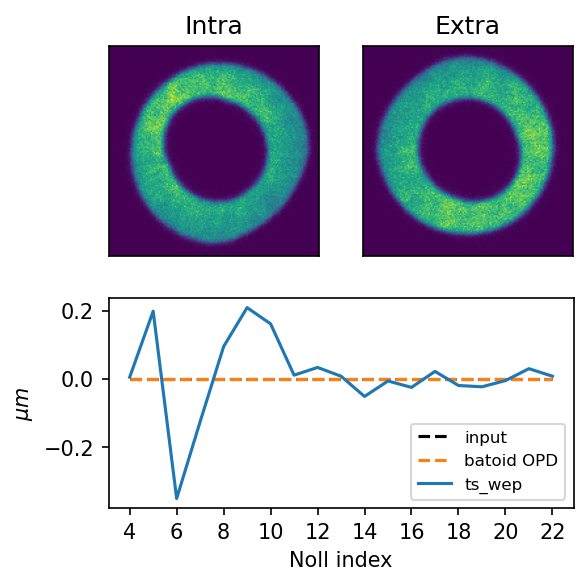

In [7]:
zk00 = 0.0 * zk0
opd00, zkEst00 = check_consistency(zk00, thx1, thy1, thx2, thy2)

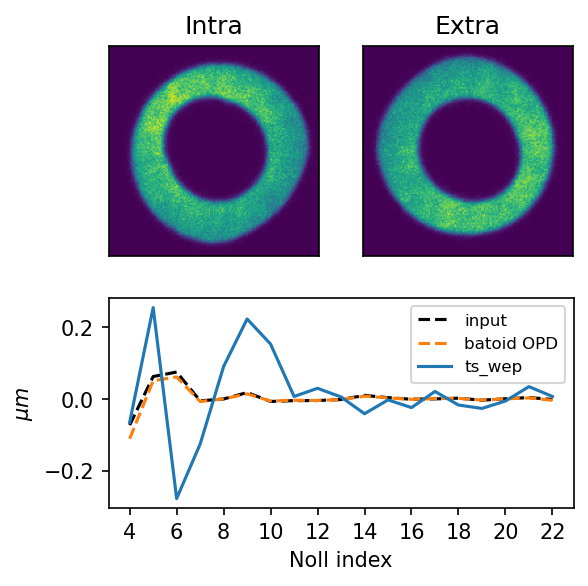

In [8]:
zk01 = 0.1 * zk0
opd01, zkEst01 = check_consistency(zk01, thx1, thy1, thx2, thy2)

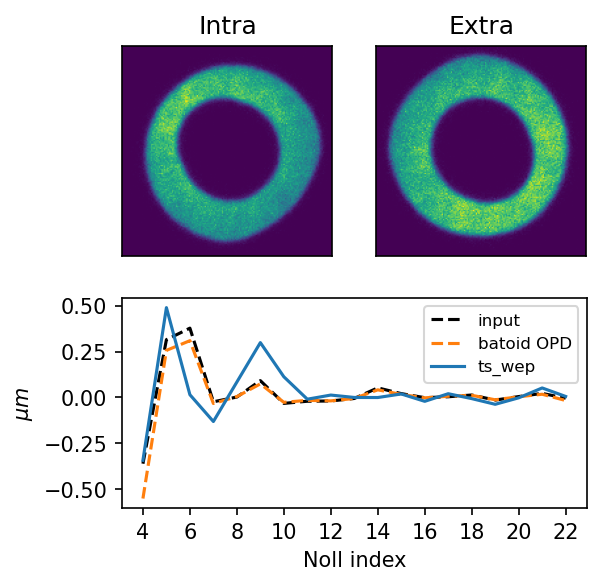

In [9]:
zk05 = 0.5 * zk0
opd05, zkEst05 = check_consistency(zk05, thx1, thy1, thx2, thy2)

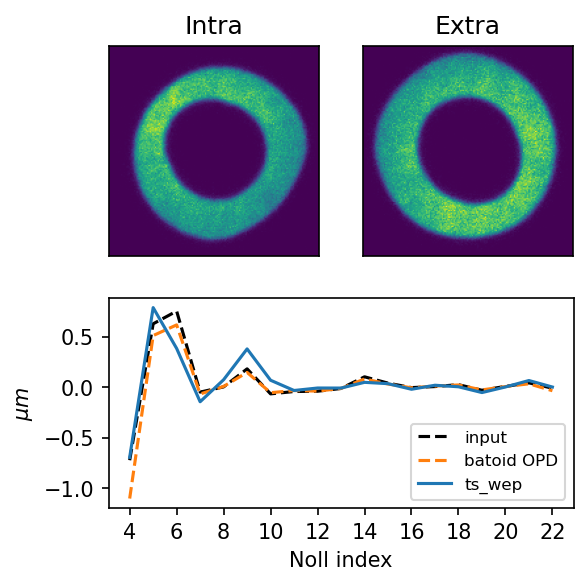

In [10]:
zk10 = 1.0 * zk0
opd10, zkEst10 = check_consistency(zk10, thx1, thy1, thx2, thy2)

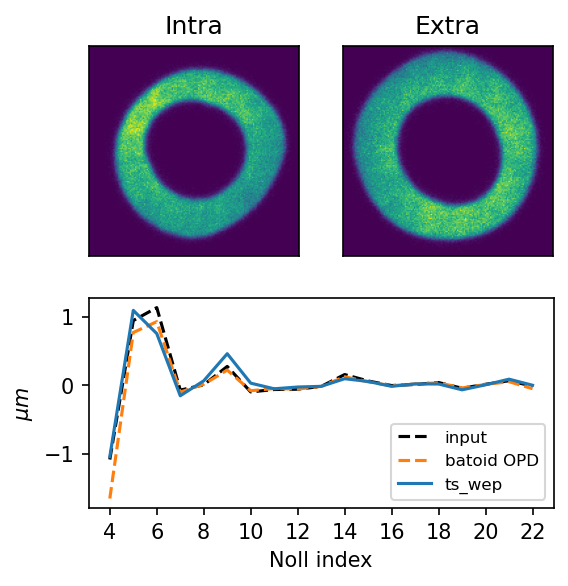

In [11]:
zk15 = 1.5 * zk0
opd15, zkEst15 = check_consistency(zk15, thx1, thy1, thx2, thy2)

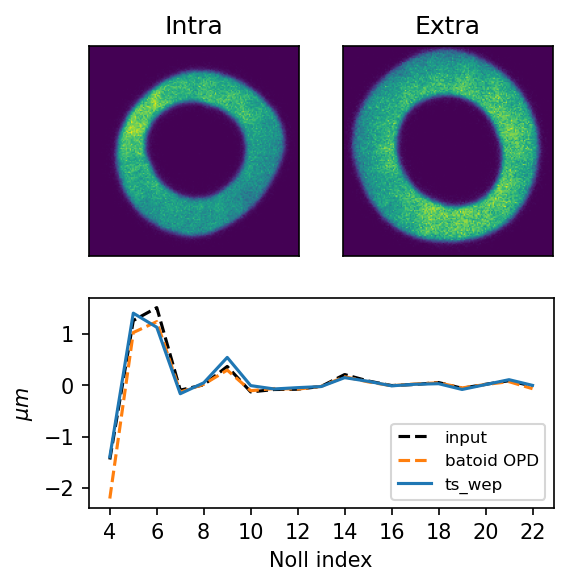

In [12]:
zk20 = 2.0 * zk0
opd20, zkEst20 = check_consistency(zk20, thx1, thy1, thx2, thy2)

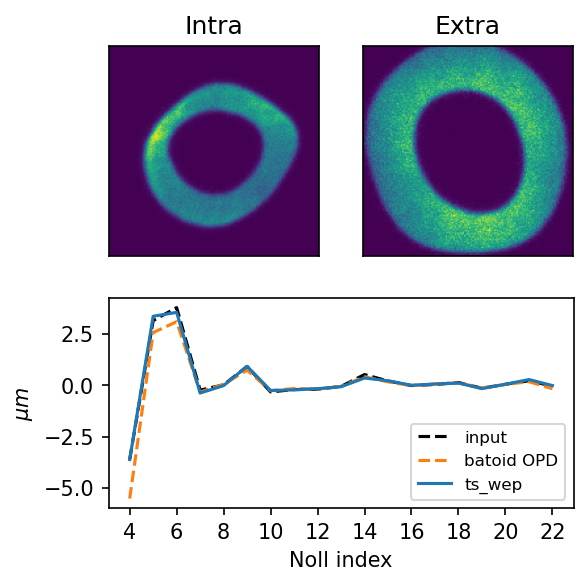

In [13]:
zk50 = 5.0 * zk0
opd50, zkEst50 = check_consistency(zk50, thx1, thy1, thx2, thy2)

## Plot bias of the batoid opd wrt the input zernikes

You can see the normalized biases are identical.

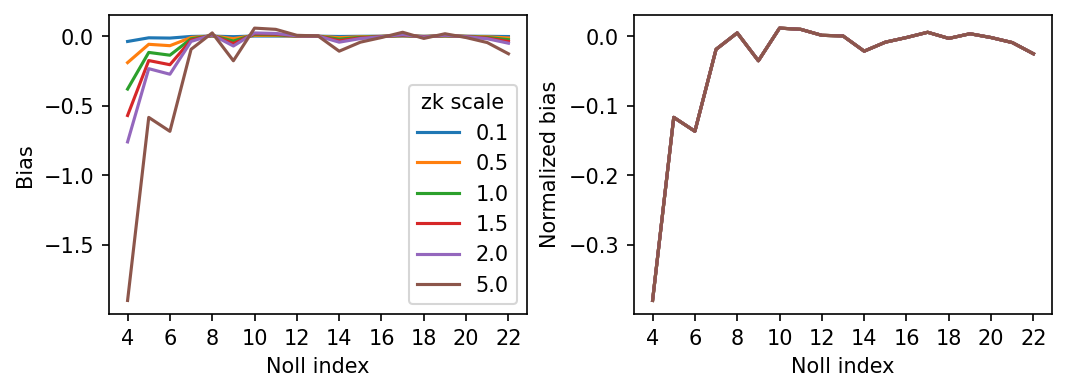

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.5), dpi=150, constrained_layout=True)

zk_grid = np.arange(4, 23)

# bias
ax1.plot(zk_grid, (opd01 - zk01), label="0.1")
ax1.plot(zk_grid, (opd05 - zk05), label="0.5")
ax1.plot(zk_grid, (opd10 - zk10), label="1.0")
ax1.plot(zk_grid, (opd15 - zk15), label="1.5")
ax1.plot(zk_grid, (opd20 - zk20), label="2.0")
ax1.plot(zk_grid, (opd50 - zk50), label="5.0")
ax1.set(xticks=np.arange(4, 23, 2), xlabel="Noll index", ylabel="Bias")
ax1.legend(title="zk scale")

# normalized bias
ax2.plot(zk_grid, (opd01 - zk01) / 0.1)
ax2.plot(zk_grid, (opd05 - zk05) / 0.5)
ax2.plot(zk_grid, (opd10 - zk10) / 1.0)
ax2.plot(zk_grid, (opd15 - zk15) / 1.5)
ax2.plot(zk_grid, (opd20 - zk20) / 2.0)
ax2.plot(zk_grid, (opd50 - zk50) / 5.0)
ax2.set(xticks=np.arange(4, 23, 2), xlabel="Noll index", ylabel="Normalized bias")

plt.show()

We actually have a multiplicative bias: $\text{input} = b \cdot \text{opd}$

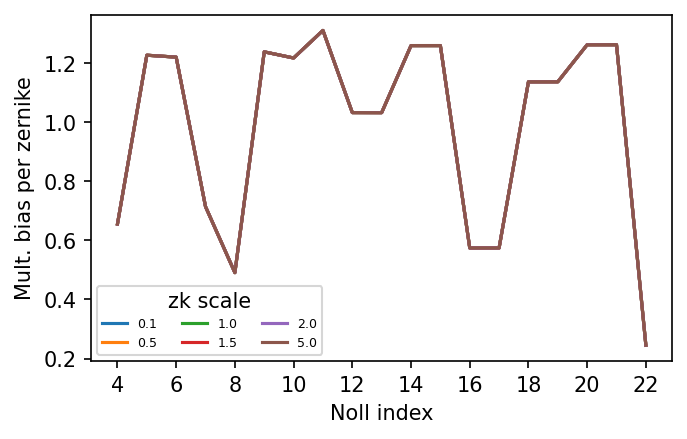

In [15]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

zk_grid = np.arange(4, 23)

ax.plot(zk_grid, zk01/opd01, label="0.1")
ax.plot(zk_grid, zk05/opd05, label="0.5")
ax.plot(zk_grid, zk10/opd10, label="1.0")
ax.plot(zk_grid, zk15/opd15, label="1.5")
ax.plot(zk_grid, zk20/opd20, label="2.0")
ax.plot(zk_grid, zk50/opd50, label="5.0")

ax.legend(title="zk scale", ncol=3, fontsize=6)
ax.set(xticks=np.arange(4, 23, 2), xlabel="Noll index", ylabel="Mult. bias per zernike")

plt.show()

In [16]:
bias = zk10/opd10
bias

array([0.65544929, 1.22731294, 1.2208211 , 0.71430264, 0.49082375,
       1.23870995, 1.21791089, 1.31114521, 1.03297969, 1.03287761,
       1.25983373, 1.25986996, 0.57440016, 0.57435971, 1.1370909 ,
       1.13725762, 1.26284848, 1.26277342, 0.24463284])

### Discussion:

- There is always consistency between the input zernikes and the batoid OPD
- EXCEPT there appears to be a multiplicative bias
- This bias is invariant to rescaling the zernikes
- BUT if you change the structure of the zernikes, the bias changes for Noll < 8

.

- ts_wep struggles to estimate zernikes for small perturbations. 
- As the zernike magnitudes are increased, ts_wep converges on the truth
- For really large zernikes, ts_wep does better than the batoid OPD for zernikes 4-6 (due to the negative bias mentioned above).